In [71]:
import pandas as pd
import numpy as np
import os
import glob

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
# from sklearn.metrics import mconean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.model_selection import backtesting_forecaster

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
pio.renderers.default = 'notebook' 
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

In [65]:
# Specify the directory
directory = 'Data/mooloolaba/'

# Use glob to find all csv files in the directory
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Read all files and concatenate them
df = pd.DataFrame()
for file in csv_files:
    _df = pd.read_csv(file, parse_dates=['Date/Time (AEST)'])
    if '_id' in _df.columns:
        _df.drop(columns=['_id'], inplace=True)
    df = pd.concat([df, _df], axis=0)

df.sort_values(by=['Date/Time (AEST)'], inplace=True)
df.set_index(keys = 'Date/Time (AEST)', inplace=True)
df = df.asfreq('30min')

df.head()

,Hs (m),Hmax (m),Tz (s),Tp (s),Peak Direction (degrees),SST (degrees C)
Date/Time (AEST),,,,,,
2022-01-01 00:00:00,2.477,4.110,6.136,8.230,90.0,25.75
2022-01-01 00:30:00,2.259,3.240,5.871,8.179,98.0,25.75
2022-01-01 01:00:00,2.268,4.280,5.752,8.174,87.0,25.80
2022-01-01 01:30:00,2.452,3.970,5.987,8.719,80.0,25.80
2022-01-01 02:00:00,2.260,3.514,5.824,8.654,90.0,25.75


[]

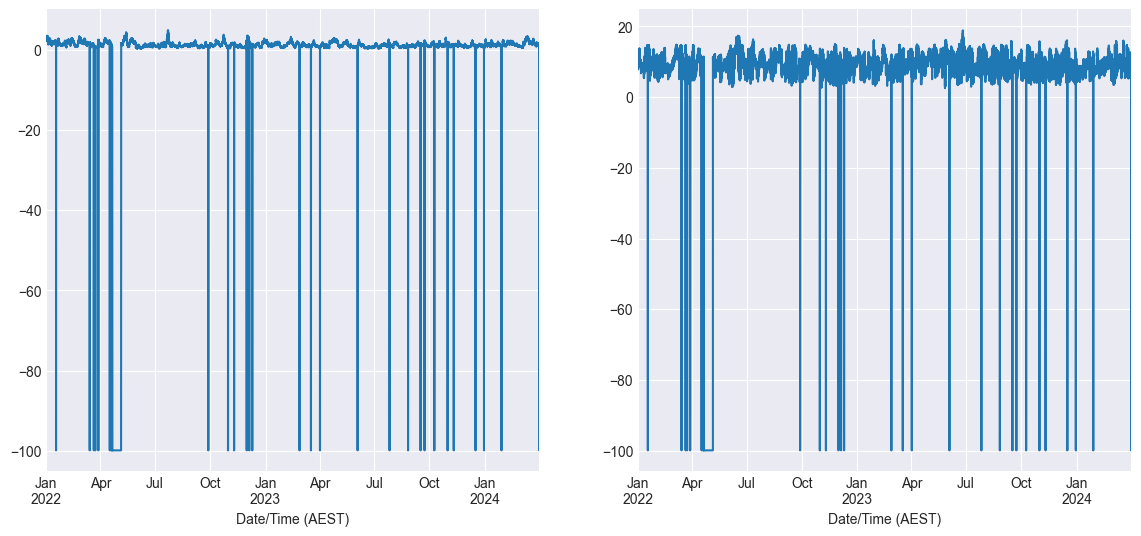

In [66]:
fig, ax = plt.subplots(1, 2, figsize = (14,6))

df['Hs (m)'].plot(ax=ax[0])
df['Tp (s)'].plot(ax=ax[1])

plt.plot()

In [52]:
# Fill missing values in the DataFrame with the rolling average of the previous `window` observations.

def fill_missing_with_rolling_avg(df, window=48, missing_value=-99.90):
    """
    Fill missing values in the DataFrame with the rolling average of the previous `window` observations.
    
    Parameters:
    df (pd.DataFrame): DataFrame with observations indexed by time.
    window (int): The number of previous observations to use for the rolling average.
    missing_value: The value in the DataFrame that represents missing values (default is -99).
    
    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    # Replace the missing value identifier with NaN
    df_replaced = df.replace(missing_value, np.nan)
    
    # Ensure the DataFrame is sorted by its index (time)
    df_replaced = df_replaced.sort_index()
    
    # Use rolling() to calculate the rolling average with the specified window size
    rolling_avg = df_replaced.rolling(window=window, min_periods=1).mean()
    
    # Fill missing values with the calculated rolling average
    df_filled = df_replaced.fillna(rolling_avg)
    
    return df_filled

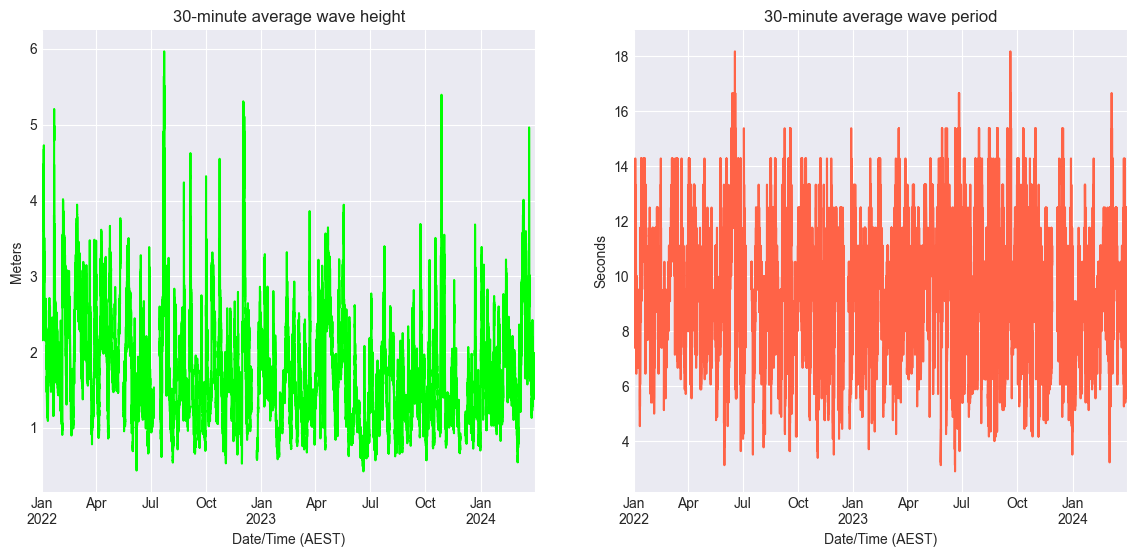

In [54]:
df_f = fill_missing_with_rolling_avg(df, window = 6)

fig, ax = plt.subplots(1, 2, figsize = (14,6))
df_f['Hs (m)'].plot(ax=ax[0], color = 'lime')
df_f['Tp (s)'].plot(ax=ax[1], color = 'tomato')

ax[0].set_ylabel('Meters')
ax[0].set_title('30-minute average wave height')
ax[1].set_ylabel('Seconds')
ax[1].set_title('30-minute average wave period')

plt.show()

In [64]:
df_f['Hs (m)'].isna().sum()

1765

In [6]:
df.shape

(39408, 6)

In [7]:
one_month = (-1)*30*24*2 # One month
two_months = (-1)*60*24*2 # Two months

end_train = one_month + two_months
end_val = one_month

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2022-01-01 00:00:00 --- 2024-01-01 23:30:00  (n=35088)
Validation dates : 2024-01-02 00:00:00 --- 2024-03-01 23:30:00  (n=2880)
Test dates       : 2024-03-02 00:00:00 --- 2024-03-31 23:30:00  (n=1440)


In [8]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['Hs (m)'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=df_val.index, y=df_val['Hs (m)'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['Hs (m)'], mode='lines', name='Test'))
fig.update_layout(
    title  = '30-minute average wave height',
    xaxis_title="Time",
    yaxis_title="Meters",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

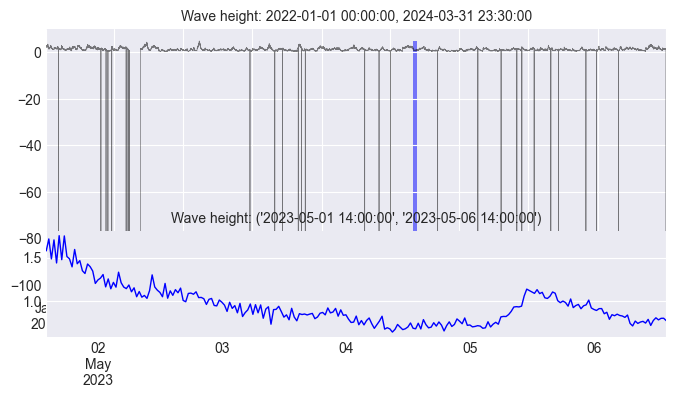

In [28]:
# Zooming time series chart
# ==============================================================================
zoom = ('2023-05-01 14:00:00','2023-05-06 14:00:00')

fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:7, :])
df['Hs (m)'].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(df['Hs (m)'])
max_y = max(df['Hs (m)'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Wave height: {df.index.min()}, {df.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
df.loc[zoom[0]: zoom[1]]['Hs (m)'].plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Wave height: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show();

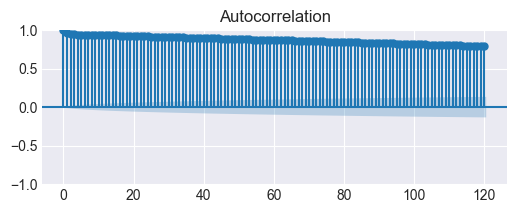

In [18]:
fig, ax = plt.subplots(figsize=(6, 2))
plot_acf(df['Hs (m)'], ax=ax, lags=120)
plt.show()

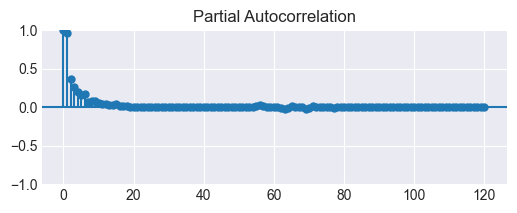

In [19]:
fig, ax = plt.subplots(figsize=(6, 2))
plot_pacf(df['Hs (m)'], ax=ax, lags=120)
plt.show()

## Baseline model

In [27]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(hours=1),
                 n_offsets = 3
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.iloc[:end_val]['Hs (m)'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: hours=1> 
Number of offsets: 3 
Aggregation function: mean 
Window size: 6 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2024-03-01 23:30:00')] 
Training index type: DatetimeIndex 
Training index frequency: 30min 
Creation date: 2024-06-24 10:07:10 
Last fit date: 2024-06-24 10:07:10 
Skforecast version: 0.12.1 
Python version: 3.11.9 
Forecaster id: None 

In [29]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df['Hs (m)'],
                          steps              = 48,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df.iloc[:end_val]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric}")

100%|██████████| 30/30 [00:00<00:00, 67.94it/s]

Backtest error (MAE): 0.27924560185185193


## Recursive multi-step forecasting

A recursive autoregressive model `ForecasterAutoreg` is trained using a gradient boosting regressor `XGBRegressor` as the base regressor. A time window of 24 hours (48 lags) is used to predict the next hour's demand. This means that the demand values of the previous 24 hours are used as predictors. The hyperparameters of the underlying regressor are left at their default values.

We add a custom weight function to ignore missing values during training. 



In [78]:
# Custom function to create weights
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is one between 2020-03-16 and 2020-06-21.
    """
    weights = np.where(df['Hs (m)']==-99.900, 0, 1)
    
    return weights

In [79]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=42,
                                        #   missing = -99.900
                                          ),
                 lags = 48,
                 weight_func = custom_weights
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.iloc[:end_val]['Hs (m)'])
forecaster

[LightGBM] [Fatal] Length of weights differs from the length of #data


LightGBMError: Length of weights differs from the length of #data

In [73]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df['Hs (m)'],
                          steps              = 48,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df.iloc[:end_val]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

# Backtesting error
# ==============================================================================
print(f'Backtest error (MAE): {metric}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 37920, number of used features: 48
[LightGBM] [Info] Start training from score -0.758039
Information of backtesting process
----------------------------------
Number of observations used for initial training: 37968
Number of observations used for backtesting: 1440
    Number of folds: 30
    Number of steps per fold: 48
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 00:00:00 -- 2024-03-01 23:30:00  (n=37968)
    Validation: 2024-03-02 00:00:00 -- 2024-03-02 23:30:00  (n=48)
Fold: 1
    Training:   2022-01-01 00:00:00 -- 2024-03-01 23:30:00  (n=37968)
    Validation: 2024-03-03 00:00:00 -- 2024-03-03 23:30:00  (n=48)
Fold: 2
    Training:   2022-01-01 00:00:00 -- 20

100%|██████████| 30/30 [00:00<00:00, 46.64it/s]

Backtest error (MAE): 57.99883615101884


In [74]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['Hs (m)'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Meters",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [45]:
df['Hs (m)'].value_counts()

Hs (m)
-99.900    762
 1.077      50
 0.926      49
 0.930      48
 0.781      47
          ... 
 4.277       1
 4.256       1
 4.213       1
 4.202       1
 2.842       1
Name: count, Length: 2926, dtype: int64

In [77]:
df['cuisi'] = np.where(df['Hs (m)']==99.90, 0, 1)
df['cuisi'].value_counts()

cuisi
1    39408
Name: count, dtype: int64

In [81]:
help(LGBMRegressor)


Help on class LGBMRegressor in module lightgbm.sklearn:

class LGBMRegressor(sklearn.base.RegressorMixin, LGBMModel)
 |  LGBMRegressor(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomState